![header](../figures/logos_partenaires._cmems_se.jpg)

# Benchmark SWOT Swath Filtering

<div style="text-align: right"><i> 2022-09-20 GAUSSIAN </i></div>

***
**Authors:**  CLS & Datlas <br>
**Copyright:** 2022 CLS & Datlas <br>
**License:** MIT

<div class="alert alert-block alert-success">
<h1><center>Benchmark of Gaussian filter</center></h1></div>

***
**General Note 1**: Execute each cell through the <button class="btn btn-default btn-xs"><i class="icon-play fa fa-play"></i></button> button from the top MENU (or keyboard shortcut `Shift` + `Enter`).<br>
<br>
**General Note 2**: If, for any reason, the kernel is not working anymore, in the top MENU, click on the <button class="btn btn-default btn-xs"><i class="fa fa-repeat icon-repeat"></i></button> button. Then, in the top MENU, click on "Cell" and select "Run All Above Selected Cell".<br>
***


<div class="alert alert-danger" role="alert">

<h3>Learning outcomes</h3>

At the end of this notebook you will know:
<ul>
  <li>How you can display unfiltered, filtered SWOT Level3 SSH products.</li>
  <li>How you can evaluate the Gomez filter: statistical and spectral analysis.</li>
</ul>
    
</div>



In [1]:
import os
import glob
import sys
sys.path.append('..')
from src.benchmark import *
from src.plot import *
from src.swot import *

<div class="alert alert-info" role="alert">

<h2>1. Input files to analyse</h2>

</div>

## Data challenge inputs

In [2]:
# Check if inputs have already been downloaded otherwise do
if not os.path.isdir('../dc_inputs'):
    # Get pseuso-observation
    !wget https://ige-meom-opendap.univ-grenoble-alpes.fr/thredds/fileServer/meomopendap/extract/MEOM/OCEAN_DATA_CHALLENGES/2022a_SWOT_karin_error_filtering/dc_inputs.tar.gz
    !tar -xvf dc_inputs.tar.gz --directory ../
    !rm -f dc_inputs.tar.gz

In [3]:
list_of_file_inputs = sorted(glob.glob('../dc_inputs/input_ssh_karin_013_*.nc')) 

## Filtered outputs to evaluate

In [4]:
list_of_file = sorted(glob.glob('../results_local/GOMEZ_V2/input_ssh_karin_013_*GOMEZ_V2.nc')) 

<div class="alert alert-info" role="alert">

<h2>2. Illustration on one pass (same as quickstart example)</h2>

</div>

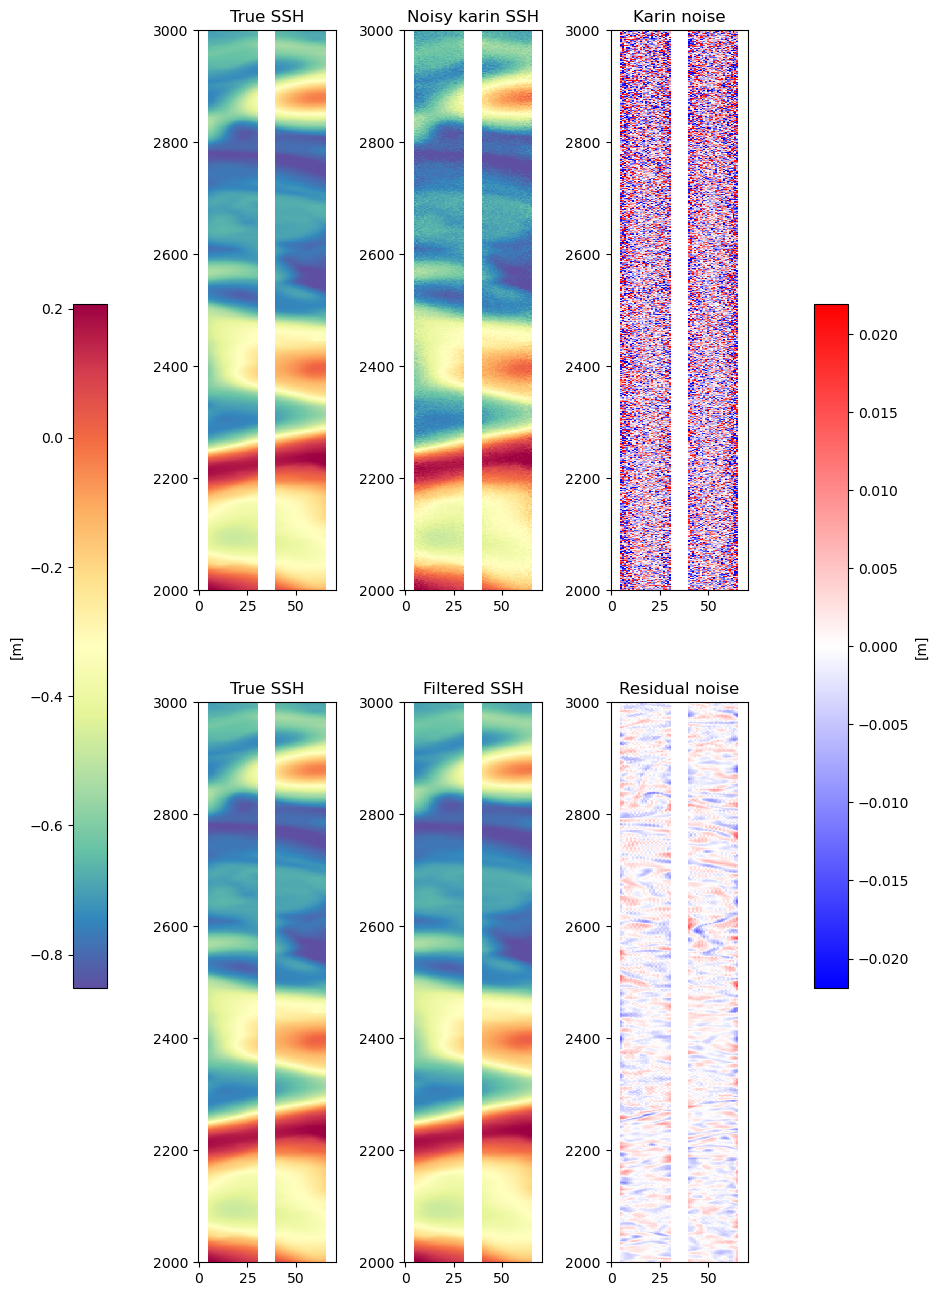

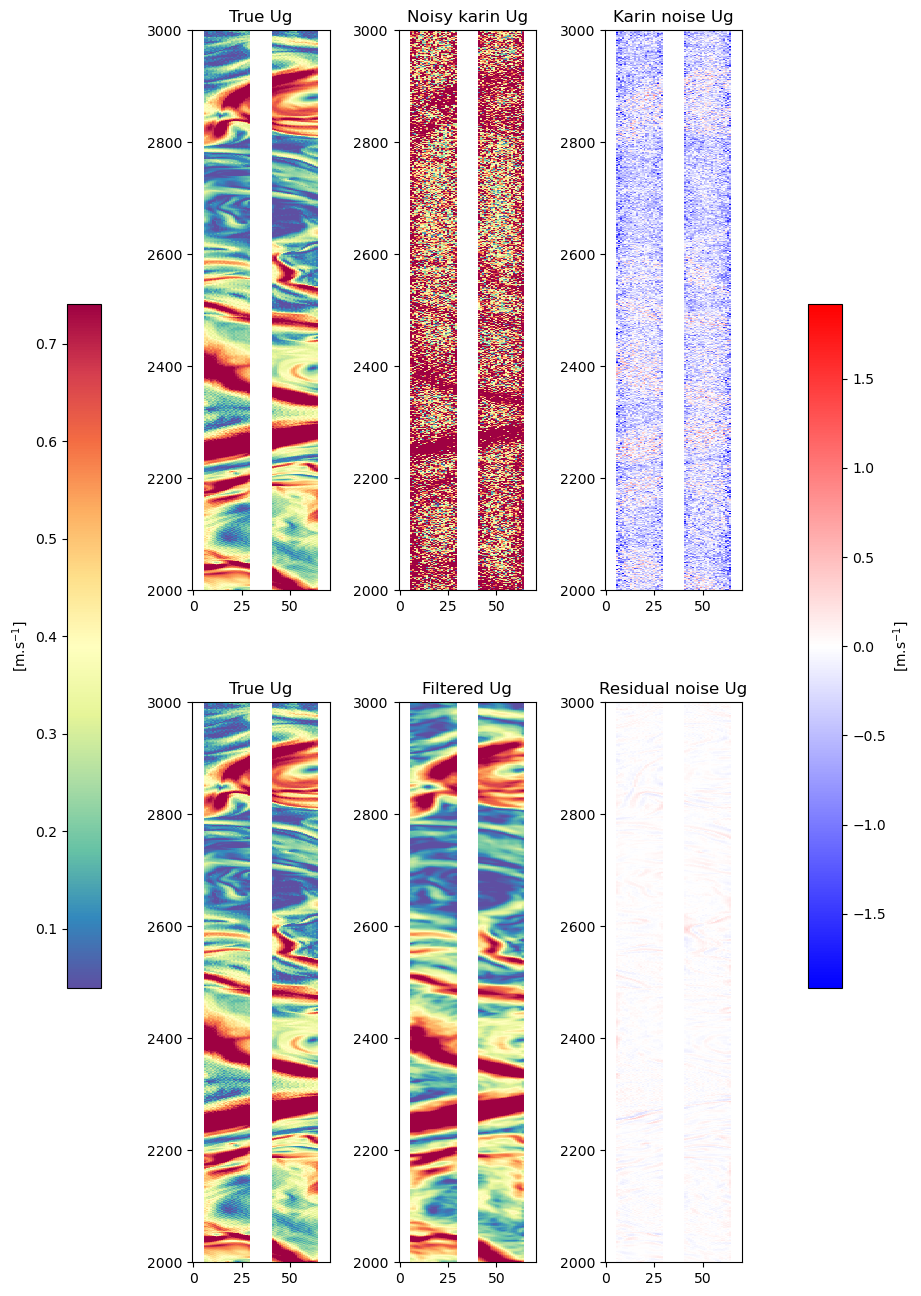

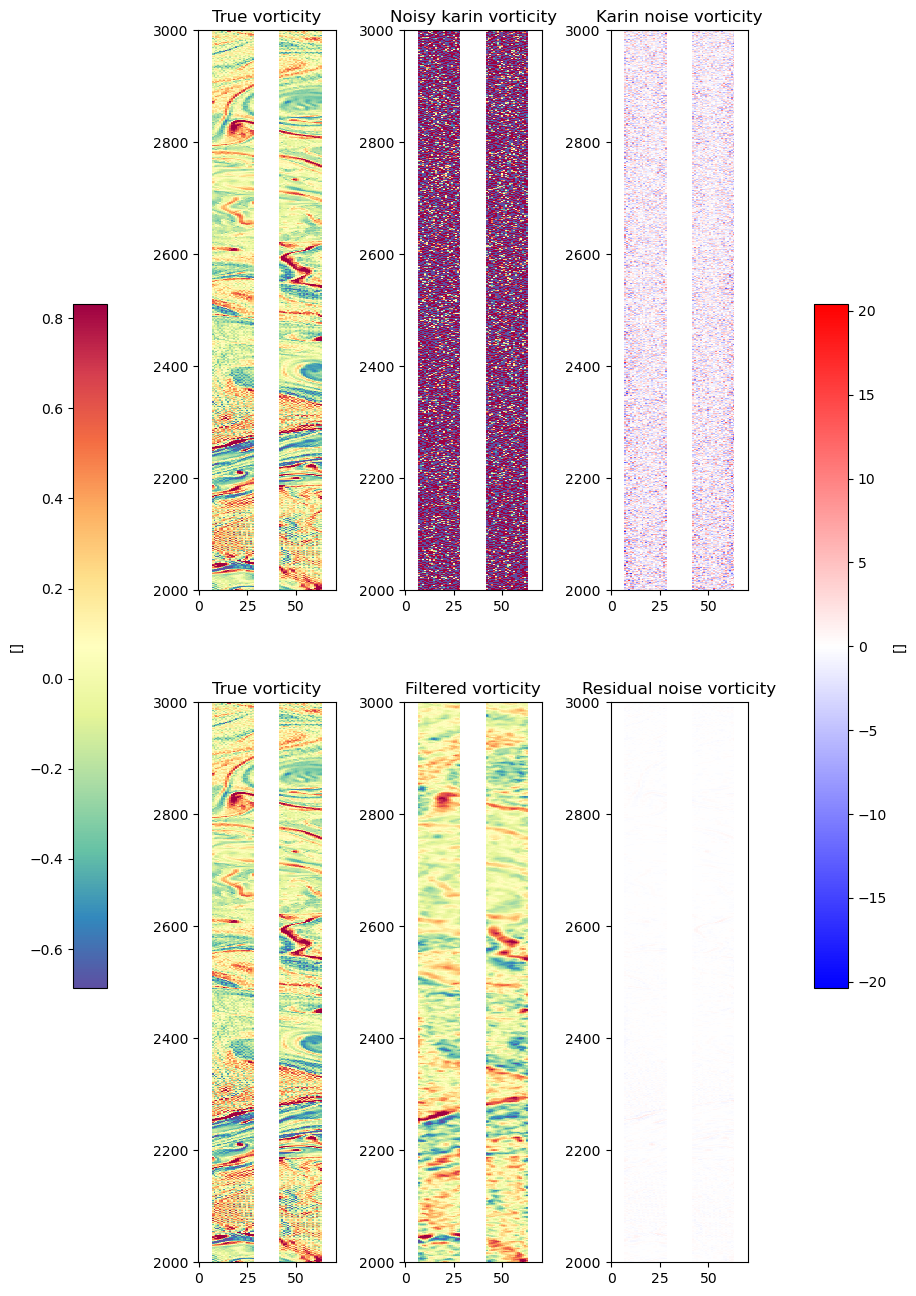

In [5]:
plot_demo_pass(list_of_file_inputs[3], list_of_file[3])

<div class="alert alert-info" role="alert">

<h2>3. Statistical & Spectral Analysis </h2>

</div>

## 3.1 Parameters

In [6]:
etuvar = 'ssh_karin_filt'
filter_name = 'GOMEZ_V2'
output_dir = '../results_local/'
stat_output_filename = f'{output_dir}/stat_'+filter_name+'.nc'
stat_by_regime_output_filename = f'{output_dir}/stat_by_regime_'+filter_name+'.nc'
psd_output_filename = f'{output_dir}/psd_'+filter_name+'.nc'
gomez_bench = Benchmark()

## 3.2 Compute grid boxes statistics

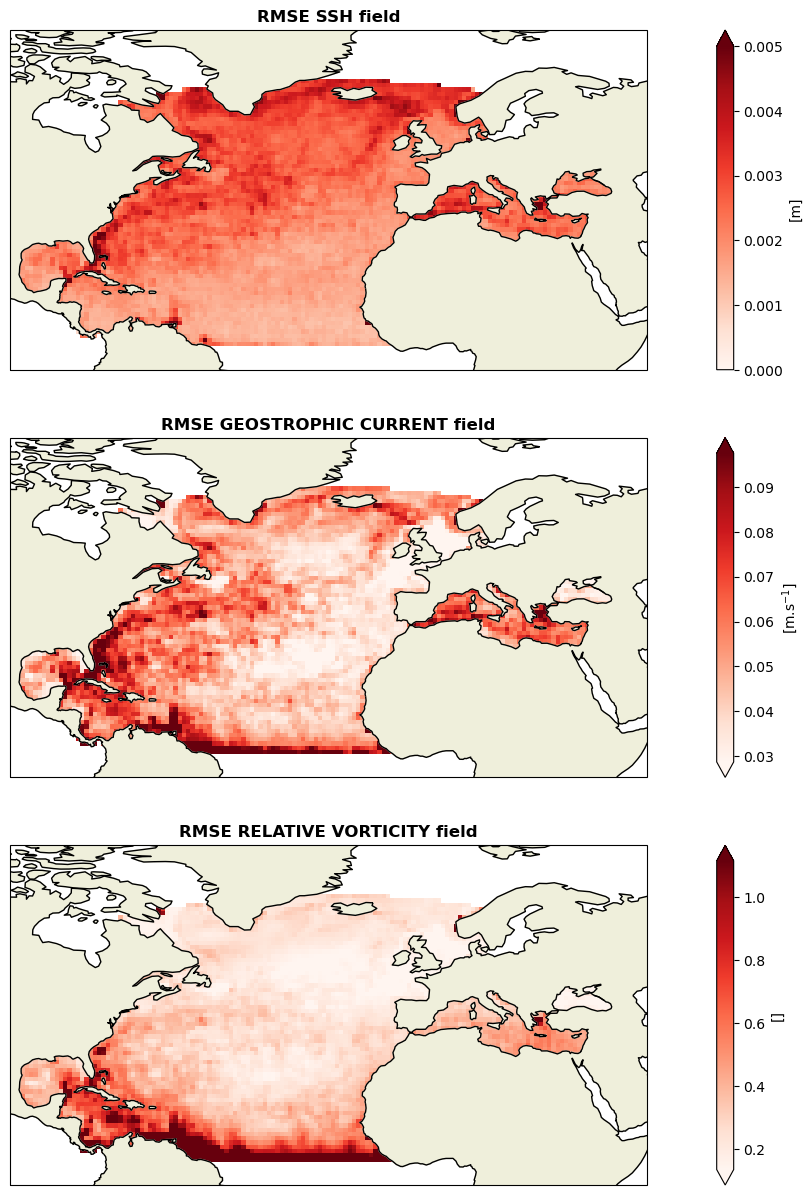

CPU times: user 56.6 s, sys: 4.75 s, total: 1min 1s
Wall time: 1min 7s


In [7]:
%%time
# Compute gridded stats
gomez_bench.compute_stats(list_of_file, etuvar, list_of_file_inputs)

# Write gridded stats 
gomez_bench.write_stats(stat_output_filename, filter=filter_name)

# Plot gridded stats
gomez_bench.display_stats(stat_output_filename, xlim=(-100, 50), ylim=(0, 80), vmin =0, vmax=0.005)

In [14]:
ds_stat= xr.open_dataset(f'{output_dir}/stat_GOMEZ_V2.nc')
print('rmse ssh',np.nanmean(ds_stat.ssh_rmse))
print('rmse vel',np.nanmean(ds_stat.ug_rmse))
print('rmse vort',np.nanmean(ds_stat.ksi_rmse))

rmse ssh 0.0026457434336714376
rmse vel 0.06036149933902124
rmse vort 0.476342715015594


## 3.3 Compute statistics by regime (coastal, offshore low variability, offshore high variability)

In [15]:
# To speed up computation
from dask.distributed import Client
client = Client(n_workers=1, threads_per_worker=1, memory_limit='8GB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 1,Total memory: 7.45 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:51498,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 1
Started: Just now,Total memory: 7.45 GiB
Comm: tcp://127.0.0.1:51504,Total threads: 1
Dashboard: http://127.0.0.1:51505/status,Memory: 7.45 GiB
Nanny: tcp://127.0.0.1:51501,


processing global
processing coastal
processing low var
processing high var
CPU times: user 4min 17s, sys: 1min 41s, total: 5min 59s
Wall time: 14min 5s


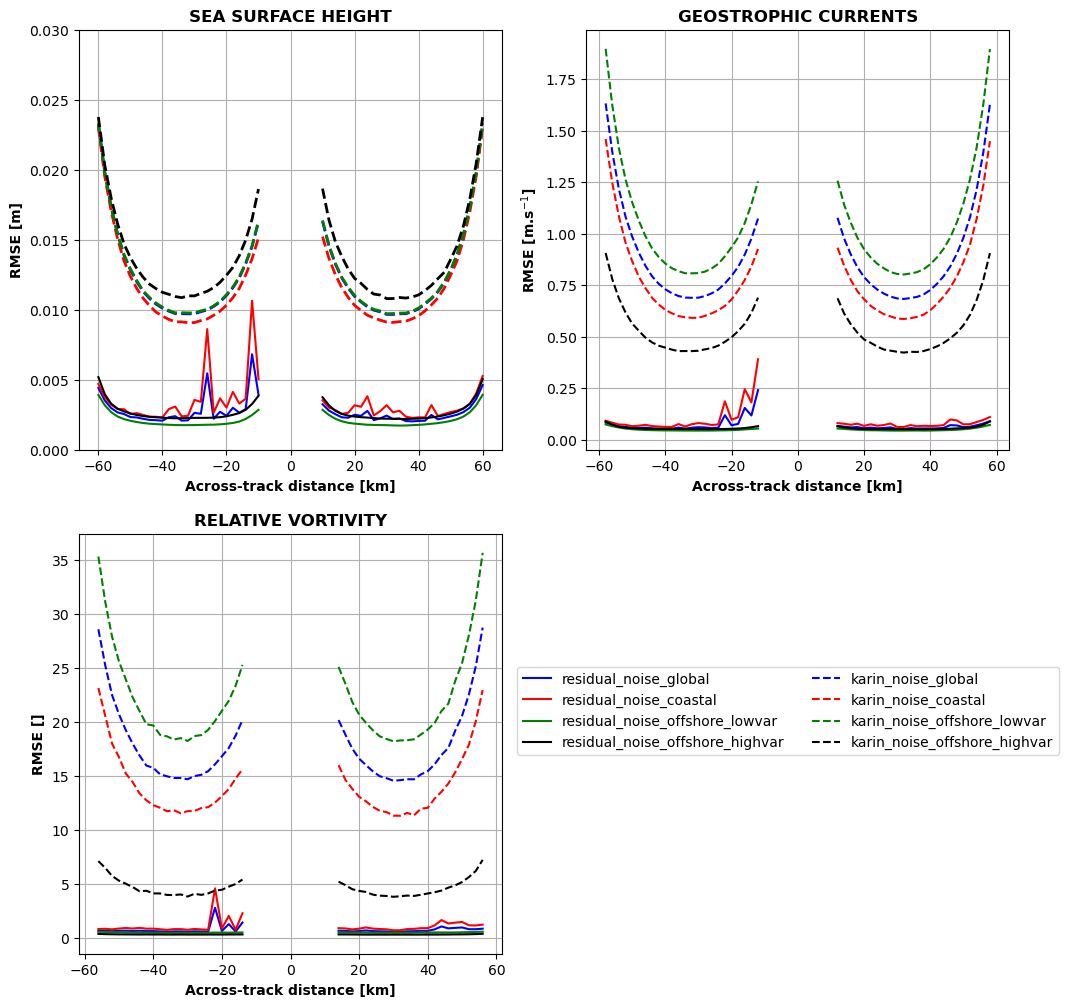

In [16]:
%%time
# Compute stats by regime
gomez_bench.compute_stats_by_regime(list_of_file, etuvar, list_of_file_inputs)

# Write stats by regime
gomez_bench.write_stats_by_regime(stat_by_regime_output_filename, filter=filter_name)

# Plot stats by regime
gomez_bench.plot_stats_by_regime(stat_by_regime_output_filename)

In [17]:
client.close()

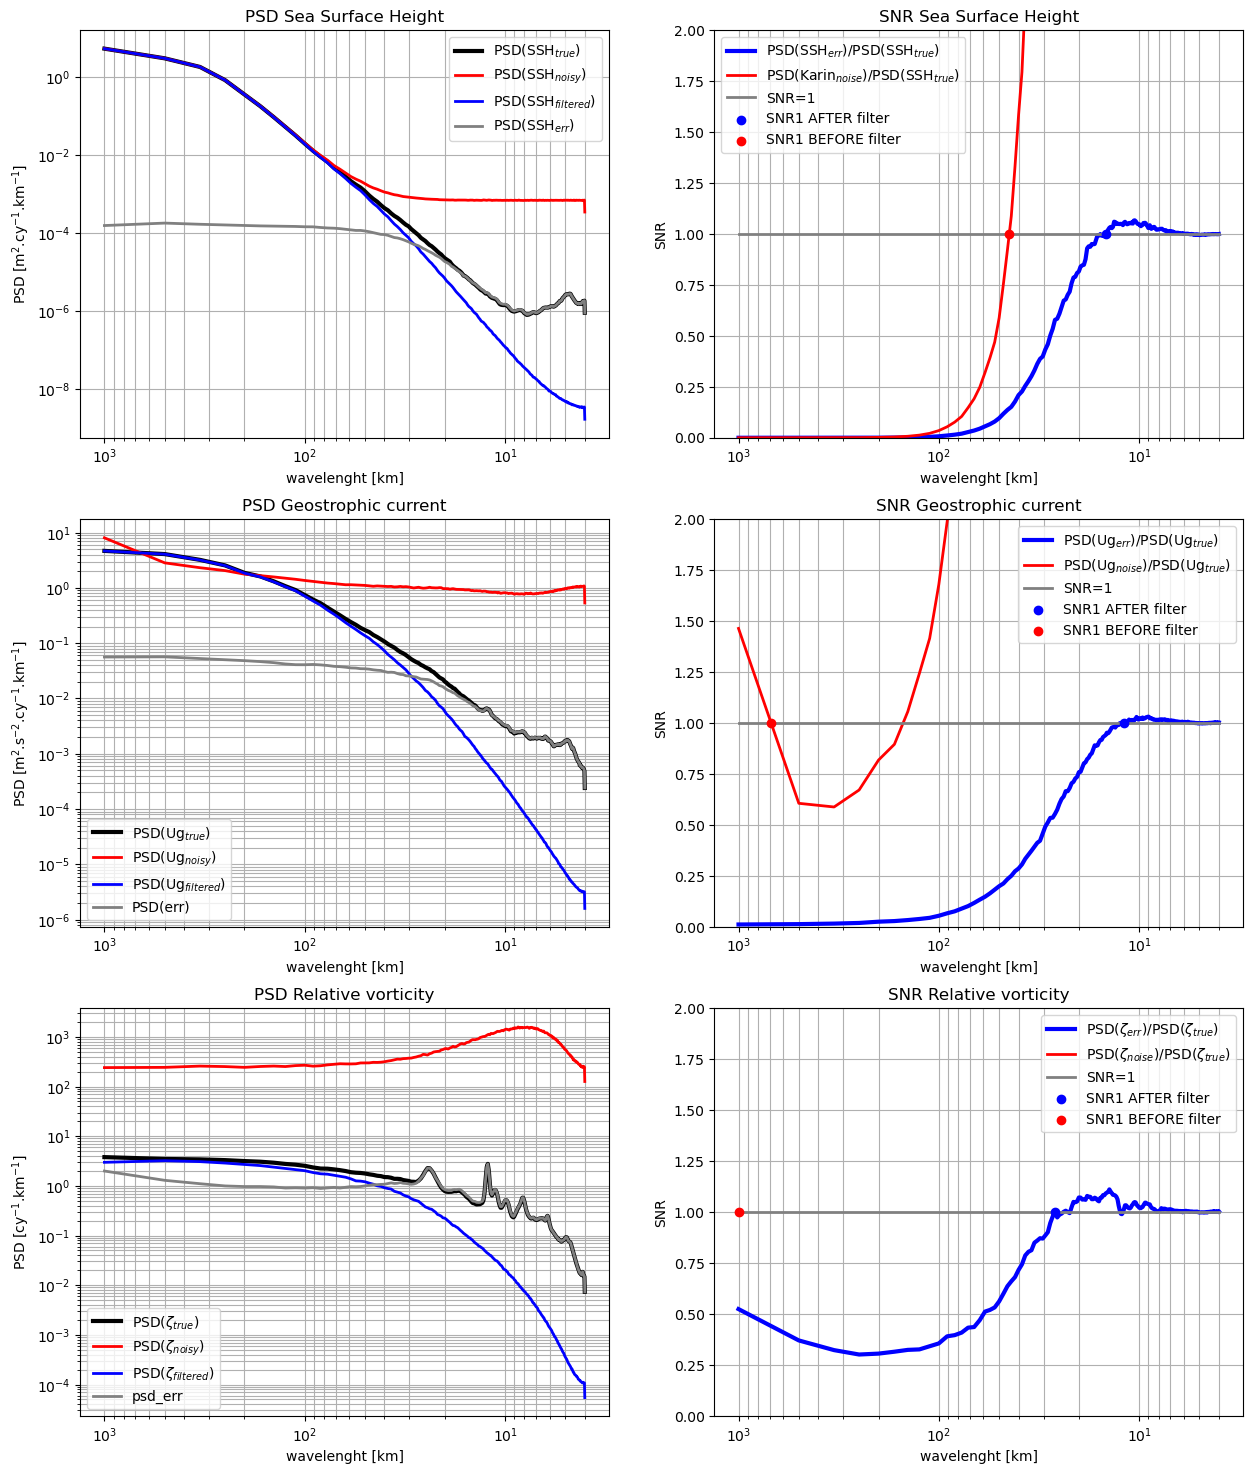

CPU times: user 46.6 s, sys: 8.73 s, total: 55.3 s
Wall time: 1min 8s


In [18]:
%%time
# Compute PSD scores
gomez_bench.compute_along_track_psd(list_of_file, etuvar,list_of_file_inputs, lengh_scale=1000)

# Write PSD scores
gomez_bench.write_along_track_psd(psd_output_filename, filter=filter_name)

# Plot PSD scores
gomez_bench.display_psd(psd_output_filename)

<div class="alert alert-info" role="alert">

<h2>4. Leaderboard </h2>

</div>

In [19]:
gomez_bench.summary('demo_benchmark_'+filter_name+'.ipynb')

Summary of the leaderboard metrics:
|    | Method        | Field                          |   µ(RMSE global) |   µ(RMSE coastal) |   µ(RMSE offshore lowvar) |   µ(RMSE offshore highvar) |   λ(SNR1) [km] | Reference                     |
|---:|:--------------|:-------------------------------|-----------------:|------------------:|--------------------------:|---------------------------:|---------------:|:------------------------------|
|  0 | BEFORE FILTER | SSH [m]                        |       0.0129638  |        0.0124429  |                0.0130138  |                 0.0140627  |           44.5 | demo_benchmark_GOMEZ_V2.ipynb |
|  1 | BEFORE FILTER | Geostrophic current [m.s$^-1$] |       0.917591   |        0.801388   |                1.07268    |                 0.545012   |          687.1 | demo_benchmark_GOMEZ_V2.ipynb |
|  2 | BEFORE FILTER | Relative vorticity []          |      18.145      |       14.3998     |               22.5588     |                 4.71851    |         